In [14]:
import json
import os
import itertools
import pandas as pd
import numpy as np
import re
from datetime import datetime as dt

import sys
sys.path.append(".\\sample")
from SALibRepastParams import num_levels, params, random_seed, init_problem, calc_second_order, policies

import batch_data_utils as bd_utils

In [15]:
with open(".//config.json") as f:
    config = json.load(f)

In [16]:
file_datetime_string = config['file_datetime_string']
vehicle_density_timestamp = config['vehicle_density_timestamp']
setting = config['setting']

gis_data_dir = os.path.abspath("..\\data\\model_gis_data")
data_dir = config['batch_data_dir']
img_dir = "..\\output\\img\\"

nbins = config['crossing_nbins']

In [17]:
output_paths = bd_utils.get_ouput_paths(file_datetime_string, vehicle_density_timestamp, data_dir)
output_sd_data = output_paths["output_sd_data"]

In [18]:
output_sd_data

'C:\\Users\\Obi Sargoni\\eclipse_workspace\\repastInterSim\\output\\batch\\model_run_data\\metrics_for_sd_analysis.2022.Apr.14.13_47_53.csv'

## Get data to analyse

In [19]:
dfDD = pd.read_csv(output_sd_data)

# get policy parameter and split the data into groups for different policies
policy_param = list(policies.keys())[0]
policy_values = policies[policy_param]
scenario_param_cols =  [i for i in params if i!=policy_param]

# Now group by scenario and aggregate to find difference in outputs between policy conditions
for c in scenario_param_cols:
	dfDD[c] = dfDD[c].astype(str) # Helps with grouping, makes matching doubles easier

dfPolicyDiff = dfDD.groupby(scenario_param_cols).agg( 	PedDistDiff = pd.NamedAgg(column = "DistPAPed", aggfunc=lambda s: s.values[0] - s.values[1]),
														VehDistDiff = pd.NamedAgg(column = "DistPAVeh", aggfunc=lambda s: s.values[0] - s.values[1]),
														PedDurDiff = pd.NamedAgg(column = "DurPAPed", aggfunc=lambda s: s.values[0] - s.values[1]),
														VehDurDiff = pd.NamedAgg(column = "DurPAVeh", aggfunc=lambda s: s.values[0] - s.values[1]),
														CrossEntDiff = pd.NamedAgg(column = "cross_entropy", aggfunc=lambda s: s.values[0] - s.values[1]),
														PedDistDiffFrac = pd.NamedAgg(column = "DistPAPed", aggfunc=lambda s: (s.values[0] - s.values[1]) / s.values[0]),
														CrossEntDiffFrac = pd.NamedAgg(column = "cross_entropy", aggfunc=lambda s: (s.values[0] - s.values[1]) / s.values[0]),
														CountRuns = pd.NamedAgg(column = "run", aggfunc=lambda s: s.shape[0]),
														RunsStr = pd.NamedAgg(column = "run", aggfunc=lambda s: ":".join(str(i) for i in s.tolist())),
													).reset_index()

for c in scenario_param_cols:
	dfPolicyDiff[c] = dfPolicyDiff[c].astype(float)

# Check that there are expected number of runs per scenario
assert (dfPolicyDiff['CountRuns']==2).all()

# Identify successfull scenarios, categorise into two groups
dfPolicyDiff['success'] = (dfPolicyDiff['PedDistDiffFrac'] > -0.1) & (dfPolicyDiff['CrossEntDiffFrac']<0) # crossing is more ordered and pedestrian trips not made too much longer on average
dfPolicyDiff['ent_decreased'] = dfPolicyDiff['CrossEntDiffFrac']<0 

print(dfPolicyDiff['success'].value_counts())
print(dfPolicyDiff['ent_decreased'].value_counts())

True     141
False     59
Name: success, dtype: int64
True     141
False     59
Name: ent_decreased, dtype: int64


## Analyse using tools in ema workbench

In [20]:
import matplotlib.pyplot as plt
from ema_workbench.analysis import prim
import seaborn as sns

assert config['setting'] == 'latin' # expect LH desig to be used when doing SD

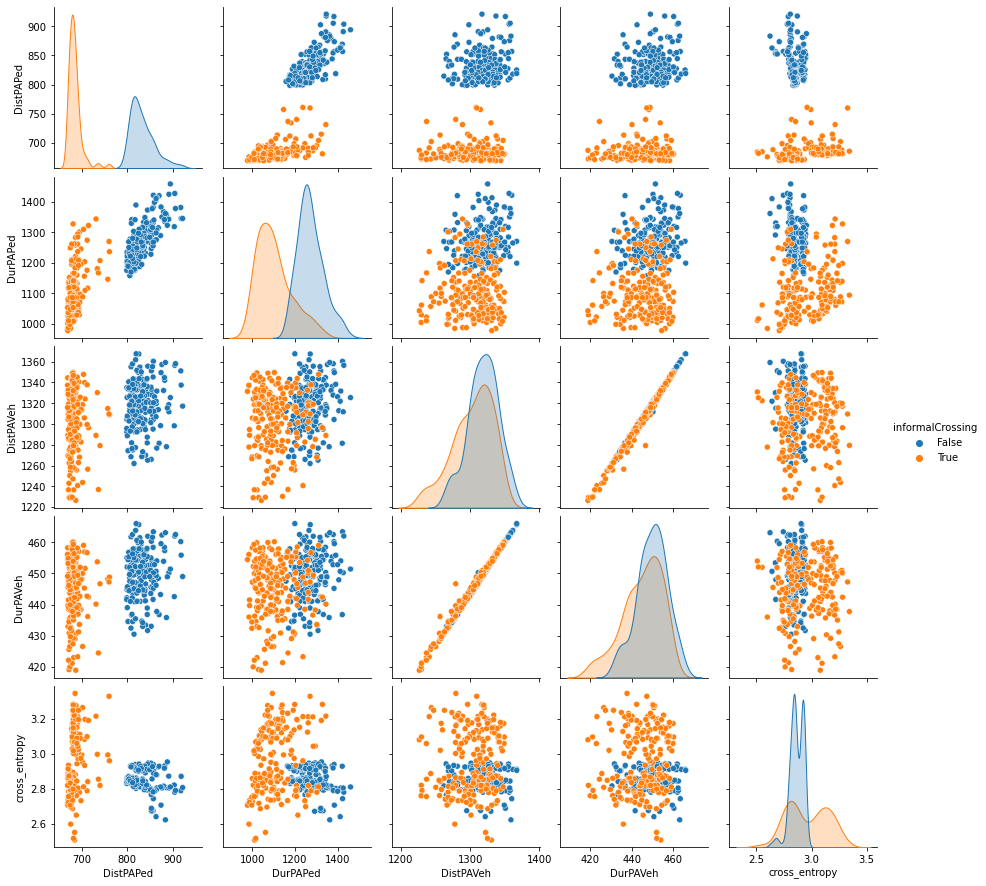

In [21]:
#
# Initial exploratory analysis of multiple outcomes
#

experiments = dfDD.loc[:, params]

outcome_vars = ['DistPAPed','DurPAPed', 'DistPAVeh', 'DurPAVeh', 'cross_entropy']
outcomes = {k:dfDD[k].values for k in outcome_vars}

# Create pairs plot
data = dfDD.loc[:, outcome_vars]
data['informalCrossing'] = experiments['informalCrossing']
sns.pairplot(data, hue='informalCrossing', vars=outcome_vars)

In [22]:
#
# PRIM analysis requires a boolean outcome variable
#
# select parameters that actually varied
varied_scenario_param_cols = [i for i in scenario_param_cols if params[i]['type']=='list']

# Now use PRIM to identify what determines policy success/failure most
x = dfPolicyDiff.loc[:, varied_scenario_param_cols].copy()
y = dfPolicyDiff['ent_decreased'].values

# Round values to make visualisations clearer
for c in ['epsilon','lambda','alpha', 'tacticalPlanHorizon']:
	x[c] = x[c].map(lambda x: np.round(x, 4))
    
prim_alg = prim.Prim(x, y, threshold=0.5)
box1 = prim_alg.find_box()

In [23]:
dfPolicyDiff['success'].value_counts()

True     141
False     59
Name: success, dtype: int64

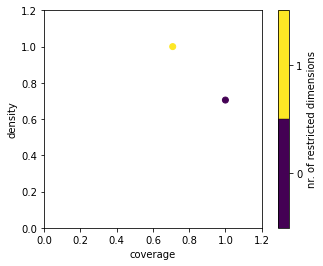

In [24]:
box1.show_tradeoff()
plt.show()

In [25]:
box1.inspect()

coverage    0.70922
density         1.0
id                1
mass            0.5
mean            1.0
res_dim           1
Name: 1, dtype: object

            box 1                                    
              min  max                      qp values
minCrossing   0.0  0.5  [-1.0, 6.590398854708596e-16]



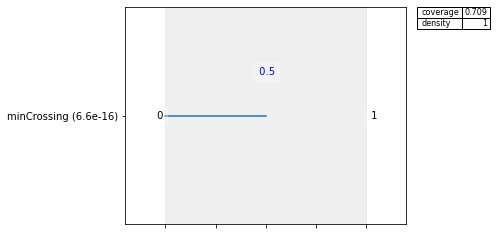

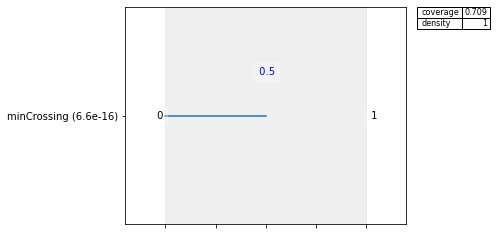

In [26]:
box1.inspect(style='graph')

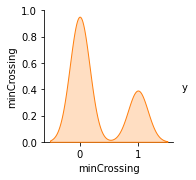

In [27]:
box1.show_pairs_scatter()

In [28]:
box2 = prim_alg.find_box()

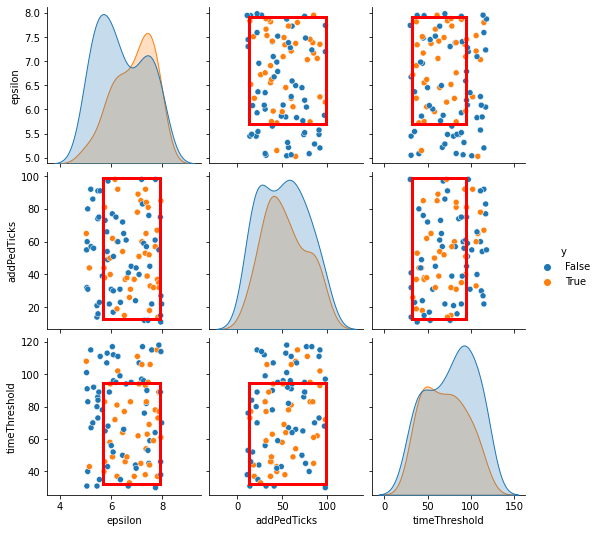

In [29]:
box2.show_pairs_scatter()

In [30]:
box2.inspect()

coverage     0.22695
density     0.653061
id                14
mass           0.245
mean        0.653061
res_dim            3
Name: 14, dtype: object

                box 14                                                     
                   min       max                                  qp values
epsilon         5.6885   7.90415  [0.04668336845689225, 0.3896285183351445]
addPedTicks    13.0000  99.00000                 [0.4166017723969655, -1.0]
timeThreshold  32.0000  94.50000  [0.4166017723969655, 0.07902662388785484]



## Investigating bimodal entropy distribution

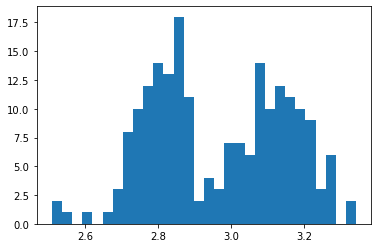

In [31]:
counts, bins, bars = plt.hist(dfDD.loc[ dfDD['informalCrossing']==True, 'cross_entropy'], bins=30)

In [32]:
counts

array([ 2.,  1.,  0.,  1.,  0.,  1.,  3.,  8., 10., 12., 14., 13., 18.,
       11.,  2.,  4.,  3.,  7.,  7.,  6., 14., 10., 12., 11., 10.,  9.,
        3.,  6.,  0.,  2.])

In [33]:
counts[14]

2.0

In [34]:
bins[14]

2.897814239507361

In [35]:
dfDD.columns

Index(['run', 'vehODSeed', 'nPeds', 'pedSpeedSeed', 'minCrossing',
       'pedMassSeed', 'addVehicleTicks', 'tacticalPlanHorizon', 'updateFactor',
       'caSampleSeed', 'randomSeed', 'epsilon', 'lambda', 'addPedTicks',
       'alpha', 'timeThreshold', 'informalCrossing', 'yieldThreshold', 'ga',
       'gamma', 'pedODSeed', 'distance', 'duration', 'nagents', 'DistPAPed',
       'DurPAPed', 'DistPAVeh', 'DurPAVeh', 'cross_entropy'],
      dtype='object')

In [36]:
dfDD.dtypes

run                      int64
vehODSeed               object
nPeds                   object
pedSpeedSeed            object
minCrossing             object
pedMassSeed             object
addVehicleTicks         object
tacticalPlanHorizon     object
updateFactor            object
caSampleSeed            object
randomSeed              object
epsilon                 object
lambda                  object
addPedTicks             object
alpha                   object
timeThreshold           object
informalCrossing          bool
yieldThreshold          object
ga                      object
gamma                   object
pedODSeed               object
distance               float64
duration                 int64
nagents                  int64
DistPAPed              float64
DurPAPed               float64
DistPAVeh              float64
DurPAVeh               float64
cross_entropy          float64
dtype: object

In [37]:
dfDD['mode'] = dfDD['cross_entropy'].map(lambda x: int(x<bins[14]))

In [38]:
varied_scenario_param_cols

['vehODSeed',
 'caSampleSeed',
 'pedMassSeed',
 'pedSpeedSeed',
 'epsilon',
 'lambda',
 'addPedTicks',
 'addVehicleTicks',
 'alpha',
 'tacticalPlanHorizon',
 'minCrossing',
 'timeThreshold']

In [41]:
# Conver variables to numeric
for c in varied_scenario_param_cols:
    if dfDD[c].dtype == 'bool':
        dfDD[c] = pd.Categorical(dfDD[c])
    elif dfDD[c].dtype == 'object':
        dfDD[c] = dfDD[c].astype(float)
    

In [42]:
'''
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() # creates the LabelEncoder object
le.fit(['<=50K', '>50K']) # we explicitly encode '<=50k' and '>50k' with 0 and 1, respectively
label_y = le.transform(original_data['over50k']) # runs LabelEncoder on the over50k column
'''

"\nfrom sklearn.preprocessing import LabelEncoder\nle = LabelEncoder() # creates the LabelEncoder object\nle.fit(['<=50K', '>50K']) # we explicitly encode '<=50k' and '>50k' with 0 and 1, respectively\nlabel_y = le.transform(original_data['over50k']) # runs LabelEncoder on the over50k column\n"

In [43]:
#from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn import tree # for decision tree models

import graphviz # for plotting decision tree graphs

In [44]:
def fitting(X, y, feature_names, criterion, splitter, mdepth, clweight, minleaf):

    # Fit the model
    model = tree.DecisionTreeClassifier(criterion=criterion, 
                                        splitter=splitter, 
                                        max_depth=mdepth,
                                        class_weight=clweight,
                                        min_samples_leaf=minleaf, 
                                        random_state=0, 
                                  )
    clf = model.fit(X, y)

    # Predict class labels on training data
    pred_labels_tr = model.predict(X)

    # Tree summary and model evaluation metrics
    print('*************** Tree Summary ***************')
    print('Classes: ', clf.classes_)
    print('Tree Depth: ', clf.tree_.max_depth)
    print('No. of leaves: ', clf.tree_.n_leaves)
    print('No. of features: ', clf.n_features_in_)
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X, y)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y, pred_labels_tr))
    print('--------------------------------------------------------')
    
    # Use graphviz to plot the tree
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=feature_names, 
                                class_names=[str(list(clf.classes_)[0]), str(list(clf.classes_)[1])],
                                filled=True, 
                                rounded=True, 
                                #rotate=True,
                               ) 
    graph = graphviz.Source(dot_data)
    
    # Return relevant data for chart plotting
    return X, y, clf, graph


In [45]:
from sklearn.feature_extraction import DictVectorizer
data_dict = dfDD.loc[:, varied_scenario_param_cols].to_dict('records')
vec = DictVectorizer()  # create the DictVectorizer object
vec_array = vec.fit_transform(data_dict).toarray()  # execute process on the record dictionaries and transform the result into a numpy array object

In [46]:
criterion = 'gini'
splitter = 'best'
mdepth = None
clweight = None
minleaf = 1

X, y, clf, graph = fitting(vec_array, dfDD['mode'].values, vec.get_feature_names(), criterion, splitter, mdepth, clweight, minleaf)

*************** Tree Summary ***************
Classes:  [0 1]
Tree Depth:  21
No. of leaves:  35
No. of features:  12
--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.9325
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       185
           1       1.00      0.87      0.93       215

    accuracy                           0.93       400
   macro avg       0.94      0.94      0.93       400
weighted avg       0.94      0.93      0.93       400

--------------------------------------------------------


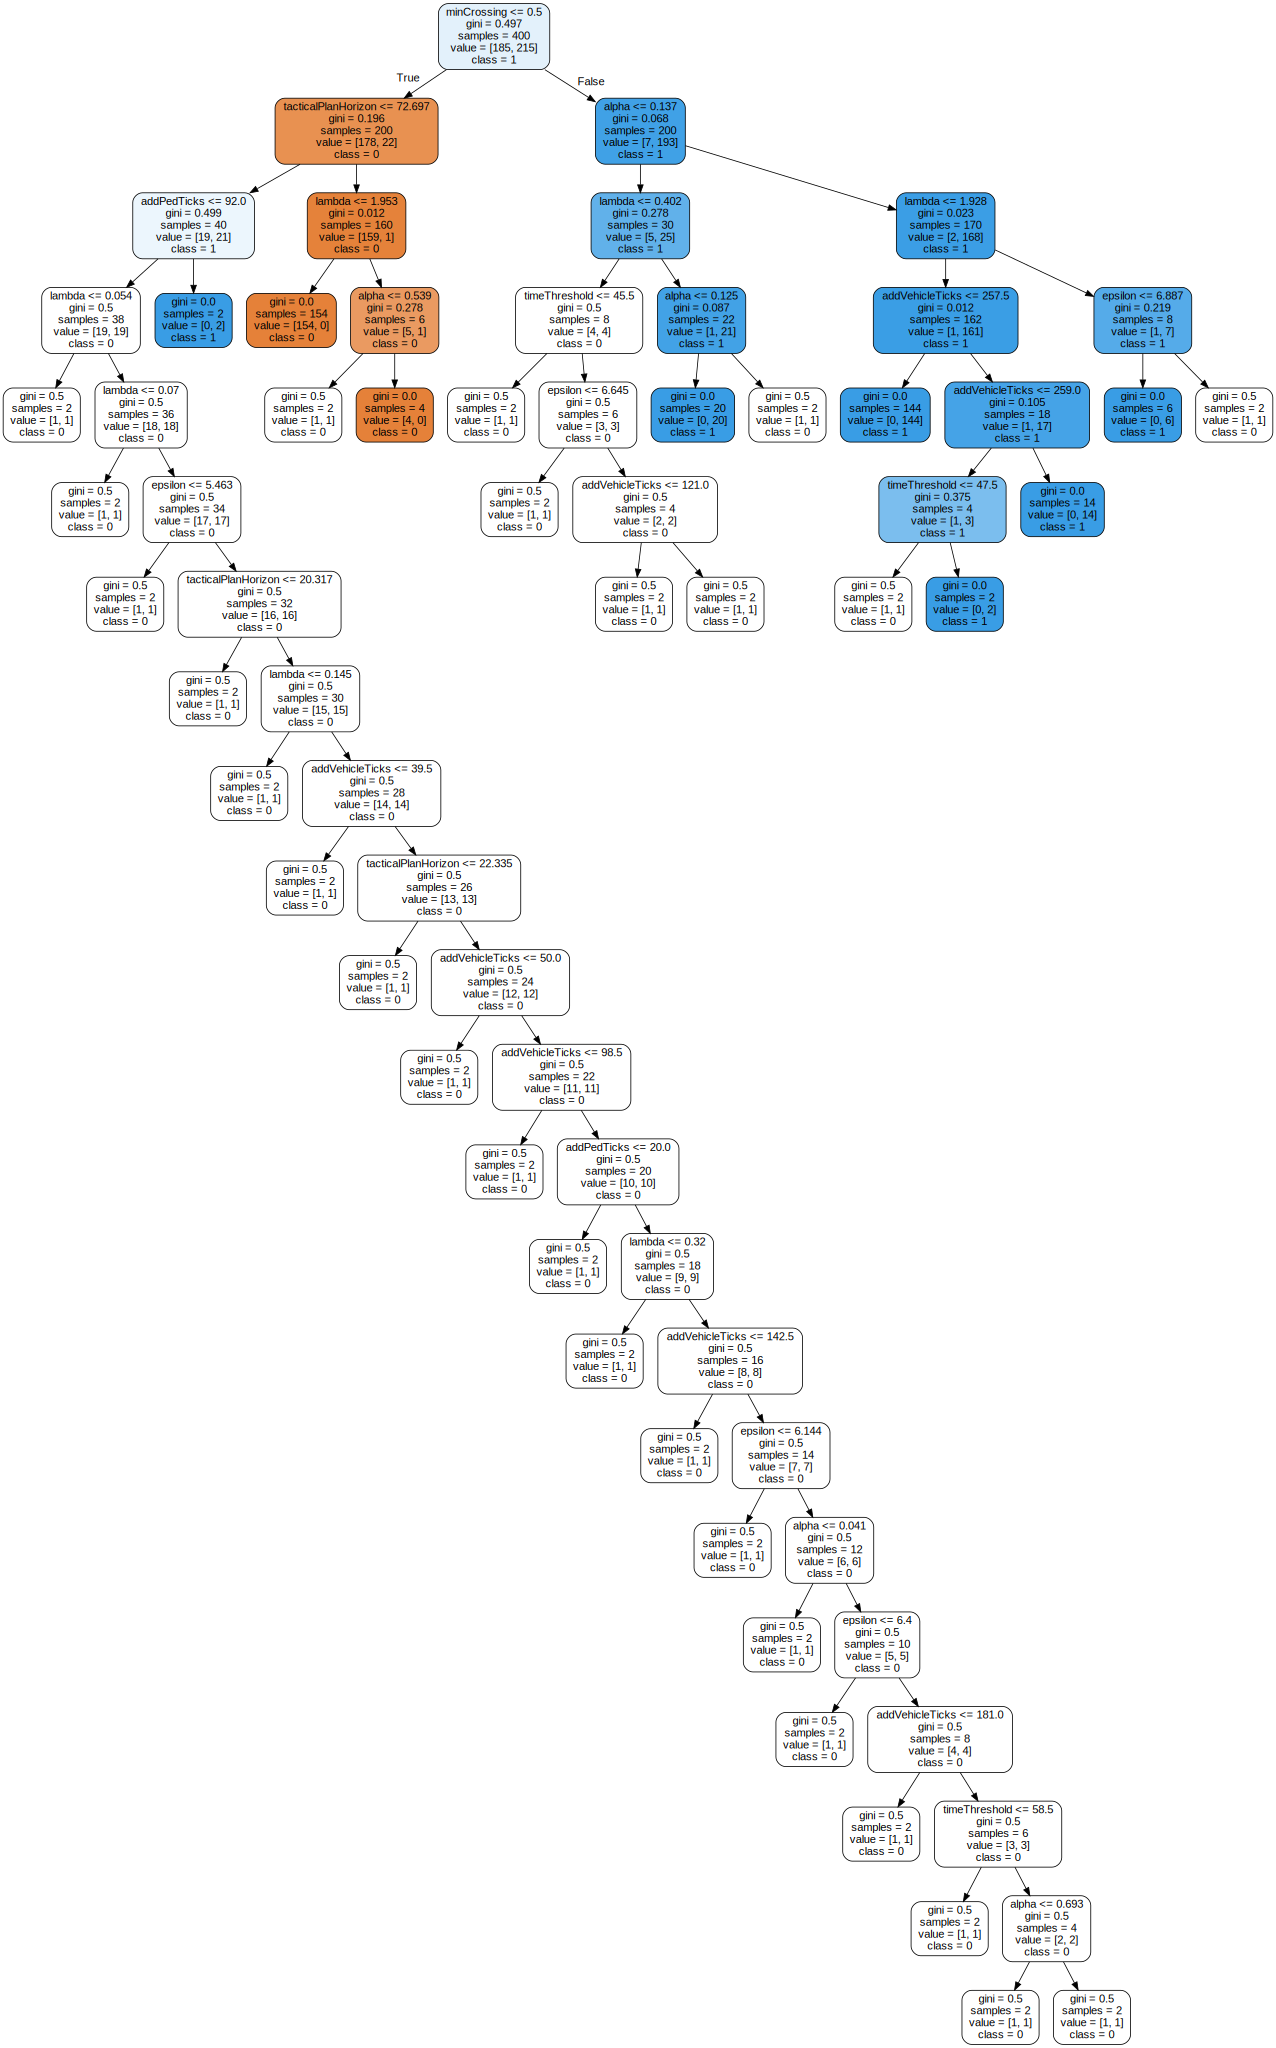

In [47]:
graph

In [48]:
clf

DecisionTreeClassifier(random_state=0)

In [49]:
clf.feature_importances_

array([0.00552727, 0.00283726, 0.0162879 , 0.        , 0.00436364,
       0.01722393, 0.85064727, 0.        , 0.        , 0.10020364,
       0.00290909, 0.        ])

In [50]:
vec.get_feature_names()

['addPedTicks',
 'addVehicleTicks',
 'alpha',
 'caSampleSeed',
 'epsilon',
 'lambda',
 'minCrossing',
 'pedMassSeed',
 'pedSpeedSeed',
 'tacticalPlanHorizon',
 'timeThreshold',
 'vehODSeed']

In [51]:
dfDD.groupby('minCrossing')['cross_entropy'].describe()

,count,mean,std,min,25%,50%,75%,max
minCrossing,,,,,,,,
0.0,200.0,3.012775,0.135594,2.780362,2.918705,2.946882,3.124544,3.343736
1.0,200.0,2.813250,0.070307,2.507633,2.787806,2.835325,2.853123,2.996641


<AxesSubplot:xlabel='cross_entropy', ylabel='Density'>

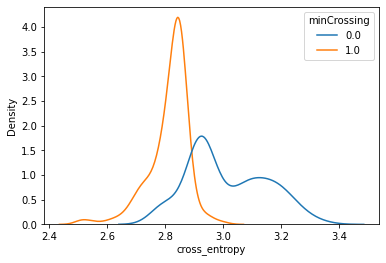

In [52]:
sns.kdeplot(data=dfDD, x="cross_entropy", hue="minCrossing")

#### Explaining these results

When agetns minimise numbers of crossings get more ordered crossing locations. This can be explained by agents crossing less frequently, specifically it appears that the types or crossings that get cut out are those in mid block locations since these are more avoidable than crossing at the end of a block, which will tend to be in the same location for many agents.

This pattern may not be reproduced for the grid world since in this case entropy is not so sensitive to the MC parameter.